In [1]:
import time
import numpy

from matplotlib import pyplot, patches

from sklearn.datasets import make_classification, load_breast_cancer, load_iris
from sklearn.preprocessing import minmax_scale, normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import KFold, LeaveOneOut


from scipy.stats import norm

from sklearn.neighbors import KernelDensity

In [2]:
class DiscriminantLineaire:
    def __init__(self, eta=1e-2, epsilon=1e-2, max_iter=1000):
        # Cette fonction est déjà  codée pour vous, vous n'avez qu'à  utiliser
        # les variables membres qu'elle définit dans les autres fonctions de
        # cette classe.
        self.eta = eta
        self.epsilon = epsilon
        self.max_iter = max_iter

    def fit(self, X, y):
        if set(y) == {0, 1}:
            y = (y * 2) - 1
        elif set(y) != {-1, 1}:
            raise Exception("The target must be {0,1} or {-1,1}")
        # Implémentez la fonction d'entraînement du classifieur, selon
        # les équations que vous avez développées dans votre rapport.

        # On initialise les poids aléatoirement
        w = numpy.random.rand(X.shape[1] + 1)

        # TODO Q2B
        # Vous devez ici implémenter l'entraînement.
        # Celui-ci devrait être contenu dans la boucle suivante, qui se répète
        # self.max_iter fois
        # Vous êtes libres d'utiliser les noms de variable de votre choix, sauf
        # pour les poids qui doivent être contenus dans la variable w définie
        # plus haut
        Err_prev = 1e10
        for i in range(self.max_iter):
            print("boucle : ",i)
            hxw_mal_classe = []
            ind_mal_classe = []
            
            for j in range(len(y)):
                Y = y[j] * ((w[1:].dot(X[j])) + w[0])
                if Y <= 0:
                    hxw_mal_classe.append((w[1:].dot(X[j])) + w[0])
                    ind_mal_classe.append(j)
            ind_mal_classe = numpy.array(ind_mal_classe)
            hxw_mal_classe = numpy.array(hxw_mal_classe)
            
            if ind_mal_classe.size:  
                normeX = numpy.linalg.norm(X[ind_mal_classe])
                num = y[ind_mal_classe] - hxw_mal_classe
                frac = (num) / (normeX**2)
                Err = 0.5 * sum((num / normeX)**2)
                deltawi = self.eta * sum(frac.dot(X[ind_mal_classe]))
                deltaw0 = self.eta * sum(frac)
            else:
                Err = 0
                deltawi = 0
                deltaw0 = 0
                
            # condition d'arrêt :
            print(Err)
            if Err_prev - Err < self.epsilon:
                print("Wololo !")
                break
            else:
                Err_prev = Err

            w[1:] += deltawi
            w[0] += deltaw0

            # à ce stade, la variable w devrait contenir les poids entraînés
            # On les copie dans une variable membre pour les conserver
        self.w = w

    def predict(self, X):
        # TODO Q2B
        # Implémentez la fonction de prédiction
        # Vous pouvez supposer que fit() a préalablement été exécuté
        return numpy.array(
            [1 if self.w[1:].dot(x) + self.w[0] >= 0
             else 0
             for x in X])

    def score(self, X, y):
        if set(y) == {0, 1}:
            y = (y * 2) - 1
        elif set(y) != {-1, 1}:
            raise Exception("The target must be {0,1} or {-1,1}")
        # TODO Q2B
        # Implémentez la fonction retournant le score (précision / accuracy)
        # du classifieur sur les données reçues en argument.
        # Vous pouvez supposer que fit() a préalablement été exécuté
        # Indice : réutiliser votre implémentation de predict() réduit de
        # beaucoup la taille de cette fonction!

        # Question 2B
        # Implémentation du classifieur un contre tous utilisant le
        # discriminant linéaire défini plus haut
        return sum([self.predict(X)[i] == y[i] for i in range(len(y))])/len(y)


In [3]:
class ClassifieurUnContreTous:
    def __init__(self, n_classes, **kwargs):
        # Cette fonction est déjà  codée pour vous, vous n'avez qu'à  utiliser
        # les variables membres qu'elle définit dans les autres fonctions de
        # cette classe.
        self.n_classes = n_classes
        self.estimators = [DiscriminantLineaire(
            **kwargs) for c in range(n_classes)]

    def fit(self, X, y):
        # TODO Q2C
        # Implémentez ici une approche un contre tous, oà¹ chaque classifieur
        # (contenu dans self.estimators) est entraîné à  distinguer une seule
        # classe versus toutes les autres
        for i in range(self.n_classes):
            target = y - i
            target[numpy.where(target != 0)] = 1
            # target = (target*2)-1 pour mettre entre -1 et 1
            # mais déjà implémenté dans le fit de Disciminant linéraire
            self.estimators[i].fit(X, target)

    def predict(self, X):
        # TODO Q2C
        # Implémentez ici la prédiction utilisant l'approche un contre tous
        # Vous pouvez supposer que fit() a préalablement été exécuté
        classes = []
        for x in X:
            Hall = [est.w[1:].dot(x) + est.w[0] for est in self.estimators]
            classes.append(numpy.argmax(Hall))
        return classes

    def score(self, X, y):
        # TODO Q2C
        # Implémentez ici le calcul du score utilisant l'approche un contre
        # tous. Ce score correspond à  la précision (accuracy) moyenne.
        # Vous pouvez supposer que fit() a préalablement été exécuté
        return sum([self.predict(X)[i] == y[i] for i in range(len(y))])/len(y)

boucle :  0
0.4153939115285605
boucle :  1
0.4115064904567654
Wololo !


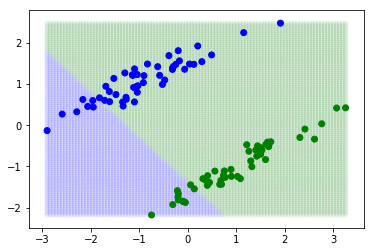

In [4]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1)


clf = DiscriminantLineaire(epsilon=1e-2)
clf.fit(X, y)
fig, sfig = pyplot.subplots(1, 1, sharex=True, sharey=True)

pas = 100
x1 = numpy.linspace(X[:, 0].min(), X[:, 0].max(), pas)
x2 = numpy.linspace(X[:, 1].min(), X[:, 1].max(), pas)
absc, ordon = numpy.meshgrid(x1, x2)
sfig.scatter(absc, ordon, alpha=0.05, s=20,
             c=["bgrcmykw"[i] for i in clf.predict(
                 numpy.c_[absc.ravel(), ordon.ravel()])])
sfig.scatter(X[:, 0], X[:, 1], c=["bgrcmykw"[i] for i in y])

pyplot.show()

In [5]:
clf.score(X,y)

0.39

In [6]:
len(y)


100

In [7]:
if plop.isempty():
    print("coucou")

NameError: name 'plop' is not defined

In [ ]:
if not False:
    print("coucou")